# Import Required Libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')


# Load The Dataset

In [81]:

df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

# Explore The Dataset

In [82]:
# Display first 10 rows
print("Preview of Dataset:")
df.head(10)

Preview of Dataset:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [83]:
# Shape of the dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")


Dataset contains 1048575 rows and 11 columns.


In [84]:
# Data types and null values
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


In [85]:
# Check for missing values
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# Preprocessing

**Target Variable Distribution**



In [86]:
# Distribution of Fraud and Non-Fraud
print("\nFraud Distribution:")
df['isFraud'].value_counts()


Fraud Distribution:


isFraud
0    1047433
1       1142
Name: count, dtype: int64

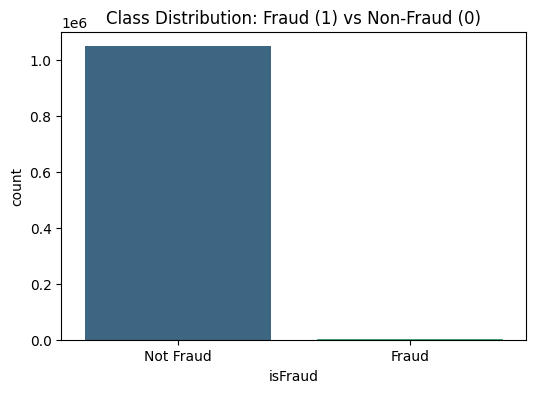

In [87]:
# Visualizing class imbalance
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='isFraud', palette='viridis')
plt.title('Class Distribution: Fraud (1) vs Non-Fraud (0)')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

**Transaction Types**

In [88]:
# Count of different transaction types
print("\nTransaction Types:")
df['type'].value_counts()


Transaction Types:


type
CASH_OUT    373641
PAYMENT     353873
CASH_IN     227130
TRANSFER     86753
DEBIT         7178
Name: count, dtype: int64

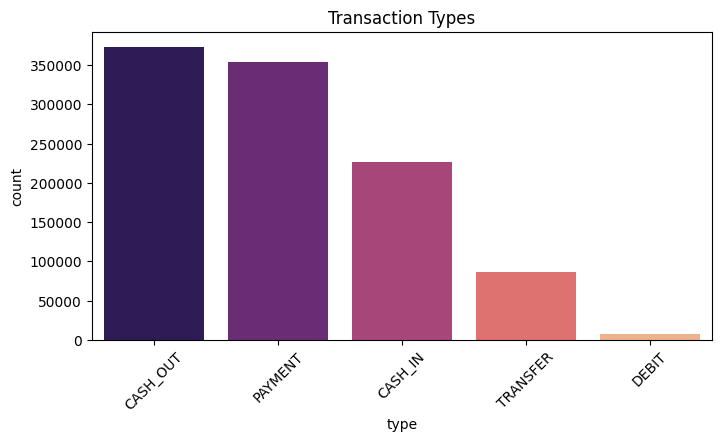

In [89]:
# Visualize transaction type frequency
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='type', order=df['type'].value_counts().index, palette='magma')
plt.title('Transaction Types')
plt.xticks(rotation=45)
plt.show()

In [90]:
#Encode transaction type numerically
df['type_encoded'] = df['type'].map({
    'PAYMENT': 0, 'TRANSFER': 1, 'CASH_OUT': 2, 'DEBIT': 3, 'CASH_IN': 4
})

In [91]:
#Select features for anomaly detection
selected_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig',
                     'oldbalanceDest', 'newbalanceDest', 'type_encoded']
X = df[selected_features]

In [92]:
#Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Amount by Fraud**

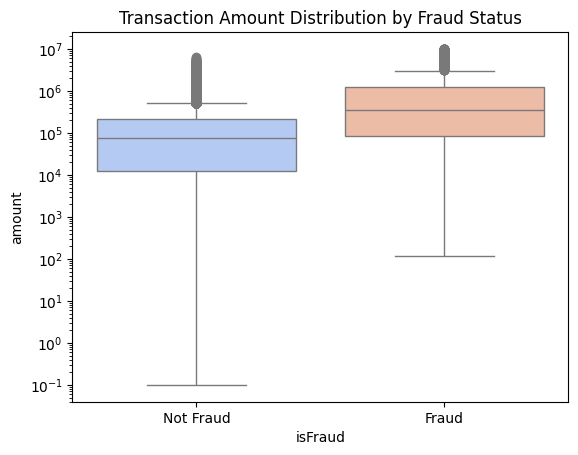

In [93]:
sns.boxplot(data=df, x='isFraud', y='amount', palette='coolwarm')
plt.yscale('log')  # Log scale for clarity
plt.title("Transaction Amount Distribution by Fraud Status")
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()


**Feature Correlations**

In [94]:
corr_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
             'newbalanceDest', 'type_encoded', 'isFraud']

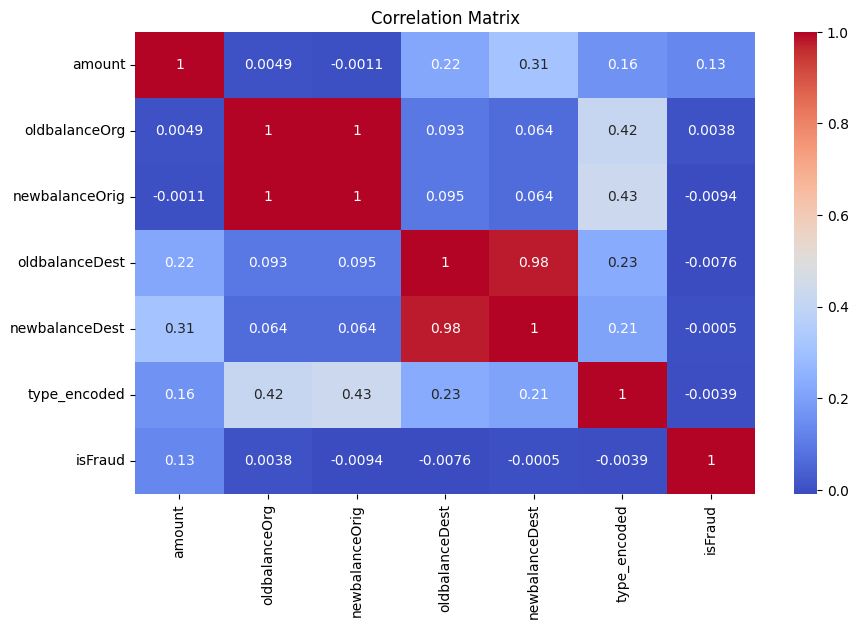

In [95]:
plt.figure(figsize=(10,6))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Model Training (Isolation_Forest)

In [96]:
# Train Isolation Forest model
iso_model = IsolationForest(n_estimators=100, 
                            contamination=0.001, 
                            random_state=42)
iso_model.fit(X_scaled)

IsolationForest(contamination=0.001, random_state=42)

# Evaluation

In [97]:
# Predict anomalies
df['anomaly_score'] = iso_model.decision_function(X_scaled)
df['is_anomaly'] = iso_model.predict(X_scaled)  # -1 = anomaly, 1 = normal
df['predicted_fraud'] = df['is_anomaly'].map({1: 0, -1: 1})  # Convert to match isFraud

In [98]:
# Classification Report
print("=== Classification Report ===")
print(classification_report(df['isFraud'], df['predicted_fraud'], digits=4))

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9989    0.9990    0.9990   1047433
           1     0.0019    0.0018    0.0018      1142

    accuracy                         0.9979   1048575
   macro avg     0.5004    0.5004    0.5004   1048575
weighted avg     0.9978    0.9979    0.9979   1048575



In [99]:
# Confusion Matrix
print("=== Confusion Matrix ===")
conf_matrix = confusion_matrix(df['isFraud'], df['predicted_fraud'])
print(conf_matrix)

=== Confusion Matrix ===
[[1046391    1042]
 [   1140       2]]


In [100]:
# Accuracy
acc = accuracy_score(df['isFraud'], df['predicted_fraud'])
print(f"\nAccuracy: {acc:.4f}")


Accuracy: 0.9979


**The model achieved 99.79% accuracy, this is misleading due to the severe class imbalance in the dataset. Both precision (0.19%) and recall (0.17%) were extremely low, indicating that the model struggled to correctly detect actual fraud cases. This shows the limitations of using Isolation Forest alone for highly imbalanced fraud data and justifies future improvements via advanced techniques like class balancing, ensemble learning, or hybrid modeling.**

# Remove Class Imabalance

In [101]:
# Separate fraud and non-fraud
fraud = df[df['isFraud'] == 1]
non_fraud = df[df['isFraud'] == 0]

# Downsample non-fraud to match fraud count
non_fraud_sample = non_fraud.sample(n=len(fraud), random_state=42)

# Combine into balanced dataset
balanced_df = pd.concat([fraud, non_fraud_sample], axis=0).sample(frac=1, random_state=42)

print("Balanced class distribution:")
print(balanced_df['isFraud'].value_counts())


Balanced class distribution:
isFraud
1    1142
0    1142
Name: count, dtype: int64


In [102]:
# Feature columns
feature_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig',
                'oldbalanceDest', 'newbalanceDest', 'type_encoded']


# Model Traning (Random Forest)

**Split the data into train and test**

In [103]:
# Define X and y
X = balanced_df[feature_cols]
y = balanced_df['isFraud']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [104]:
# Train model
rf = RandomForestClassifier(n_estimators=100,
                             random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [105]:
# Predict
y_pred = rf.predict(X_test)

# Evaluation

In [106]:
# Predict
y_pred = rf.predict(X_test)

In [107]:
#Classification Report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9814    0.9634    0.9723       328
           1     0.9670    0.9832    0.9751       358

    accuracy                         0.9738       686
   macro avg     0.9742    0.9733    0.9737       686
weighted avg     0.9739    0.9738    0.9737       686



In [108]:
#Confusion Matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Confusion Matrix ===
[[316  12]
 [  6 352]]


In [109]:
#Accuracy Score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.9738


# Results Comparison

**Create a performance comparison table**

In [110]:
# Define performance metrics for both models
comparison_data = {
    "Model": ["Isolation Forest", "Random Forest"],
    "Accuracy": [0.9979, 0.9738],
    "Precision": [0.0019, 0.9670],
    "Recall": [0.0018, 0.9832],
    "F1-Score": [0.0018, 0.9751]
}

In [111]:
# Create DataFrame
comparison_df_final = pd.DataFrame(comparison_data)

# Melt for visualization
comparison_melted_final = comparison_df_final.melt(id_vars="Model", var_name="Metric", value_name="Score")

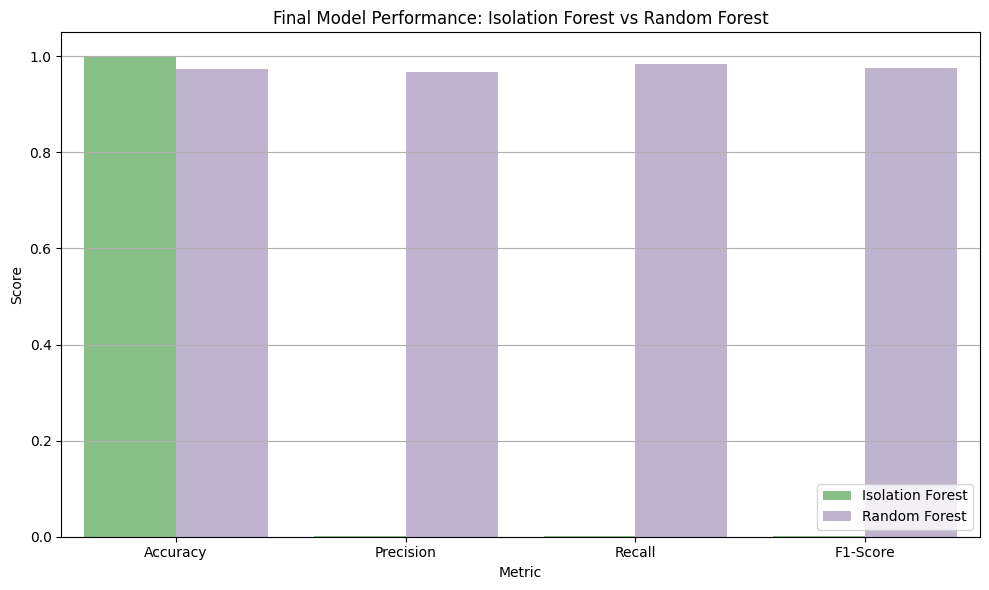

In [112]:
# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_melted_final, x="Metric", y="Score", hue="Model", palette="Accent")
plt.title("Final Model Performance: Isolation Forest vs Random Forest")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.legend(loc="lower right")
plt.tight_layout()